# **Hotel Booking Cancellation Prediction**



**1. Import**

In [1]:
import pandas as pd
import numpy as np

**2. Dataset**

In [2]:
data = pd.read_csv('booking.csv')

data.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


**3. Drop Useless Data**

In [3]:
data.drop(['Booking_ID', 'P-not-C'], axis=1, inplace=True)


**4. Set X & Y**

In [4]:
# Transformisemo 'date of reservation' u datetime
data['date of reservation'] = pd.to_datetime(data['date of reservation'],errors='coerce')

# Delimo 'date of reservation' na delove kako bi posle pravili dummy varijable
data['reservation_year'] = data['date of reservation'].dt.year
data['reservation_month'] = data['date of reservation'].dt.month
data['reservation_day'] = data['date of reservation'].dt.day
data['reservation_dayofweek'] = data['date of reservation'].dt.dayofweek

# Uklanjamo 'date of reservation' jer je redundantno obelezje
data = data.drop(['date of reservation'], axis=1)

data.dropna(subset=['reservation_year', 'reservation_month', 'reservation_day', 'reservation_dayofweek'], inplace=True)

# Uzimamo sve sem 'booking status' za X, a y ce nam biti statistika da li je otkazana rezervacija ili ne
X = data.drop(['booking status'], axis=1)
y = data['booking status']

# Pravimo dummy varijable
X = pd.get_dummies(X)

**5. Train and Test Split**

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape[0])
print(len(y_train))

32623
32623


**6. Standardize 'Average Price'**

In [6]:
from sklearn.preprocessing import StandardScaler

# Inicijalizacija
s = StandardScaler()

# Sada cemo standardizovati jedino numericko obelezje
s.fit(X_train[['average price']])

x_train_std = s.transform(X_train[['average price']])
x_test_std = s.transform(X_test[['average price']])

x_train_std = pd.DataFrame(x_train_std, columns=['average price'])
x_test_std = pd.DataFrame(x_test_std, columns=['average price'])

# Vise nam ne treba staro obelezje, tako da ga odbacujemo
X_train = X_train.drop(columns=['average price'])
X_test = X_test.drop(columns=['average price'])

# Resetujemo indekse kako bi spojili nepromenjena obelezja sa 'average price'
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
x_train_std.reset_index(drop=True, inplace=True)
x_test_std.reset_index(drop=True, inplace=True)

# Vrsimo konkatenaciju
X_train = pd.concat([x_train_std, X_train], axis=1)
X_test = pd.concat([x_test_std, X_test], axis=1)

# Provera vrednosti
print(X_train.head())
print(X_test.head())


   average price  number of adults  number of children  \
0      -0.040411                 2                   0   
1      -0.612680                 2                   0   
2      -0.752189                 1                   0   
3       0.585953                 2                   0   
4       0.158887                 2                   0   

   number of weekend nights  number of week nights  car parking space  \
0                         2                      2                  0   
1                         0                      1                  0   
2                         1                      1                  0   
3                         0                      3                  0   
4                         2                      1                  0   

   lead time  repeated  P-C  special requests  ...  room type_Room_Type 3  \
0          4         0    0                 1  ...                  False   
1         30         0    0                 0  ...        

**7. K-Nearest Neighbors**

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Biramo parametre koje cemo testirati
parameters = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ('hamming', 'euclidean', 'manhattan')}

# Inicijalizacija KNN klasifikatora
knn = KNeighborsClassifier()

# Inicijalizacija GridSearchCV-a sa KNN i parametrima
grid_search = GridSearchCV(knn, parameters, cv=5, scoring='accuracy', verbose=3)

# Vrsimo 'fit' na podacima
grid_search.fit(X_train, y_train)

# Ispis najboljih parametara i njihovu tacnost
best_knn_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best model:", best_knn_model)
print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .....metric=hamming, n_neighbors=3;, score=0.818 total time=   2.4s
[CV 2/5] END .....metric=hamming, n_neighbors=3;, score=0.819 total time=   2.6s
[CV 3/5] END .....metric=hamming, n_neighbors=3;, score=0.812 total time=   2.5s
[CV 4/5] END .....metric=hamming, n_neighbors=3;, score=0.815 total time=   2.7s
[CV 5/5] END .....metric=hamming, n_neighbors=3;, score=0.821 total time=   2.7s
[CV 1/5] END .....metric=hamming, n_neighbors=5;, score=0.818 total time=   3.7s
[CV 2/5] END .....metric=hamming, n_neighbors=5;, score=0.819 total time=   3.5s
[CV 3/5] END .....metric=hamming, n_neighbors=5;, score=0.815 total time=   3.4s
[CV 4/5] END .....metric=hamming, n_neighbors=5;, score=0.819 total time=   3.5s
[CV 5/5] END .....metric=hamming, n_neighbors=5;, score=0.820 total time=   3.6s
[CV 1/5] END .....metric=hamming, n_neighbors=7;, score=0.818 total time=   3.5s
[CV 2/5] END .....metric=hamming, n_neighbors=7;

**8. Support Vector Machines**

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Biramo parametre koje cemo testirati
parameters = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale']}

# Inicijalizacija klasifikatora na bazi vektora nosaca
svm_classifier = SVC()

# Inicijalizacija GridSearchCV-a sa SVM i parametrima
grid_search_svm = GridSearchCV(svm_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Vrsimo 'fit' na podacima
grid_search_svm.fit(X_train, y_train)

# Ispis najboljih parametara i njihovu tacnost
best_svm_model = grid_search_svm.best_estimator_
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

print("Best SVM model:", best_svm_model)
print("Best SVM parameters:", best_params_svm)
print("Best SVM score:", best_score_svm)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.793 total time=  16.8s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.805 total time=  14.2s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.802 total time=  16.2s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.799 total time=  13.1s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.802 total time=  14.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.743 total time=  29.3s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.745 total time=  29.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.743 total time=  28.8s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.748 total time=  28.9s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.752 total time=  29.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.744 total time=  20.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;,

**9. Decision Tree**

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Biramo parametre koje cemo testirati
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Inicijalizacija klasifikatora stabla odluke
tree_classifier = DecisionTreeClassifier()

# Inicijalizacija GridSearchCV-a sa DTC i parametrima
grid_search_tree = GridSearchCV(tree_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Vrsimo 'fit' na podacima
grid_search_tree.fit(X_train, y_train)

# Ispis najboljih parametara i njihovu tacnost
best_tree_model = grid_search_tree.best_estimator_
best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_

print("Best Decision Tree model:", best_tree_model)
print("Best Decision Tree parameters:", best_params_tree)
print("Best Decision Tree score:", best_score_tree)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.864 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.866 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.859 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.872 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.876 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.865 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.865 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.856 total time= 

**10. Test Best Solutions**

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# Inicijalizujemo KNN sa najboljim parametrima za dati skup podataka
best_knn_model = KNeighborsClassifier(n_neighbors=3, metric='manhattan')

# Treniramo trening skup podataka
best_knn_model.fit(X_train, y_train)

# Evaluiramo performanse KNN modela sa datim podacima
knn_accuracy = best_knn_model.score(X_test, y_test)
print("Accuracy of the final KNN model:", knn_accuracy)

Accuracy of the final KNN model: 0.8237241379310345


In [27]:
from sklearn.svm import SVC

# Inicijalizujemo SVM sa najboljim parametrima za dati skup podataka
best_svm_model = SVC(C=0.1, kernel='linear', gamma='scale')

# Treniramo trening skup podataka
best_svm_model.fit(X_train, y_train)

# Evaluiramo performanse SVM modela sa datim podacima
svm_accuracy = best_svm_model.score(X_test, y_test)
print("Accuracy of the final SVM model:", svm_accuracy)

Accuracy of the final SVM model: 0.791448275862069


In [28]:
from sklearn.tree import DecisionTreeClassifier

# Inicijalizujemo DTC sa najboljim parametrima za dati skup podataka
best_dtc_model = DecisionTreeClassifier(max_depth=20, criterion='entropy', min_samples_leaf=1, min_samples_split=2)

# Treniramo trening skup podataka
best_dtc_model.fit(X_train, y_train)

# Evaluiramo performanse DTC modela sa datim podacima
dtc_accuracy = best_dtc_model.score(X_test, y_test)
print("Accuracy of the final LDA model:", dtc_accuracy)

Accuracy of the final LDA model: 0.8673103448275862


In [29]:
# Ocena najboljeg KNN modela
knn_test_score = best_knn_model.score(X_test, y_test)
print("Accuracy of the KNN model on the test set:", knn_test_score)

# Ocena najboljeg SVM modela
svm_test_score = best_svm_model.score(X_test, y_test)
print("Accuracy of the SVM model on the test set:", svm_test_score)

# Ocena najboljeg DTC modela
dtc_test_score = best_dtc_model.score(X_test, y_test)
print("Accuracy of the Decision Tree Classifier model on the test set:", dtc_test_score)

Accuracy of the KNN model on the test set: 0.8237241379310345
Accuracy of the SVM model on the test set: 0.791448275862069
Accuracy of the Decision Tree Classifier model on the test set: 0.8673103448275862


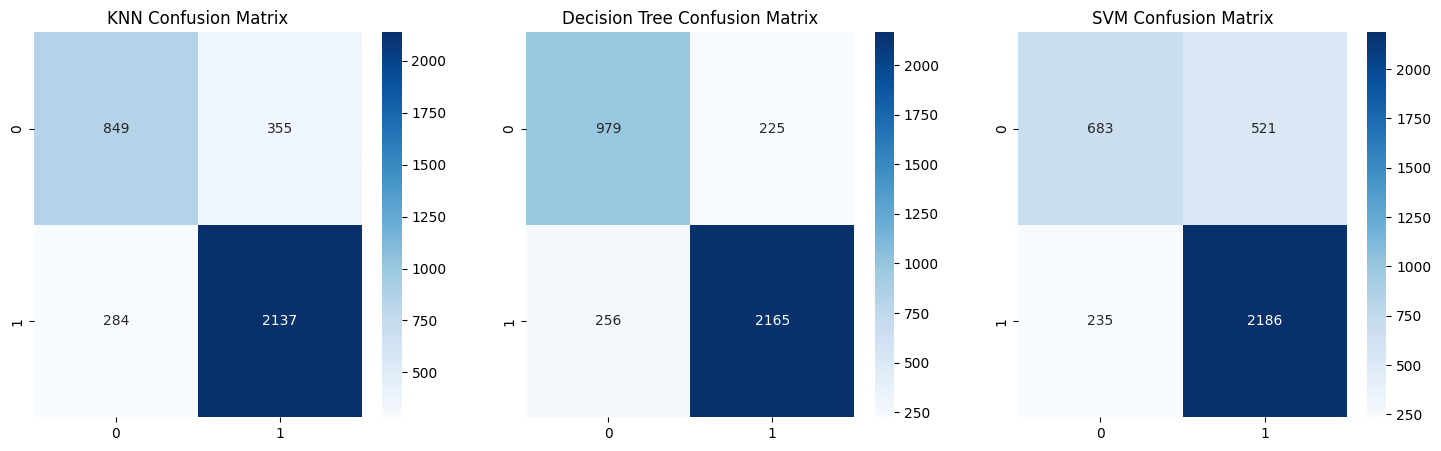

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Vrsimo predikciju koristeci najbolji KNN model
knn_pred = best_knn_model.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_pred)

# Vrsimo predikciju koristeci najbolji DTC model
dtc_pred = best_dtc_model.predict(X_test)
dtc_conf_matrix = confusion_matrix(y_test, dtc_pred)

# Vrsimo predikciju koristeci najbolji SVM model
svm_pred = best_svm_model.predict(X_test)
svm_conf_matrix = confusion_matrix(y_test, svm_pred)

# Uradicemo prikaz matrica konfuzije za date modele
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# KNN matrica konfuzije
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title('KNN Confusion Matrix')

# DTC matrica konfuzije
sns.heatmap(dtc_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[1])
axes[1].set_title('Decision Tree Confusion Matrix')

# SVM matrica konfuzije
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap="Blues", ax=axes[2])
axes[2].set_title('SVM Confusion Matrix')

plt.show()

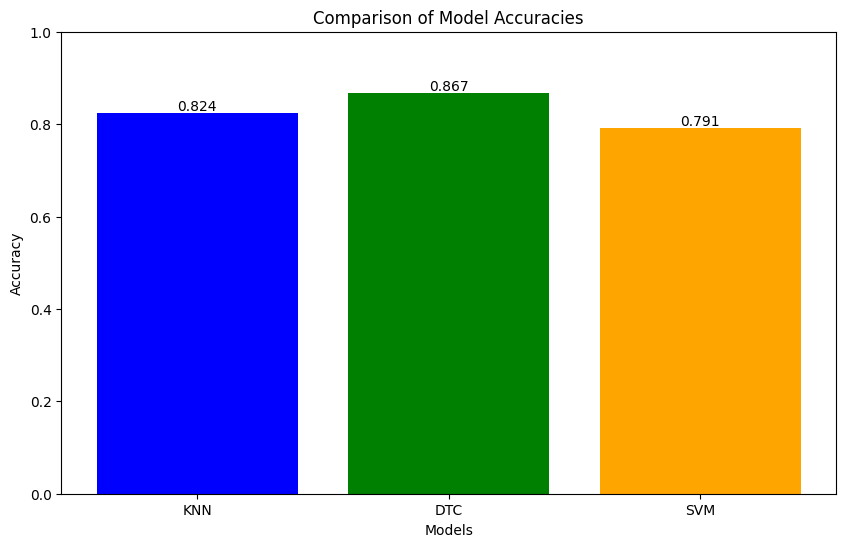

In [31]:
from sklearn.metrics import accuracy_score

# Racunamo preciznosti sva tri modela
accuracy_knn = accuracy_score(y_test, knn_pred)
accuracy_dtc = accuracy_score(y_test, dtc_pred)
accuracy_svm = accuracy_score(y_test, svm_pred)

accuracies = [accuracy_knn, accuracy_dtc, accuracy_svm]
models = ['KNN', 'DTC', 'SVM']

# Uradicemo bar plot da prikazemo razliku u preciznosti
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Naslov i labele
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Dodajemo preciznosti iznad bar plotova 
for index, value in enumerate(accuracies):
    plt.text(index, value, str(round(value, 3)), ha='center', va='bottom')

# Ispis slike
plt.ylim(0, 1)
plt.show()

**11. Test All Models With LDA**

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Inicijalizacija LDA modela
lda = LinearDiscriminantAnalysis(n_components=1)

# Vrsimo 'fit' nad svim trening podacima
X_train_lda = lda.fit_transform(X_train, y_train)

# Transformisemo test skup, pri cemu sada vrsimo analizu nasih podataka sa redukcijom dimenzionalnosti
X_test_lda = lda.transform(X_test)

print(X_train_lda.shape[0])
print(len(y_train))

32623
32623


**12. KNN With LDA**

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Biramo parametre koje cemo testirati
parameters = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ('hamming', 'euclidean', 'manhattan')}

# Inicijalizacija KNN klasifikatora
knn = KNeighborsClassifier()

# Inicijalizacija GridSearchCV-a sa KNN i parametrima
grid_search = GridSearchCV(knn, parameters, cv=5, scoring='accuracy', verbose=3)

# Vrsimo 'fit' na podacima
grid_search.fit(X_train_lda, y_train)

# Ispis najboljih parametara i njihovu tacnost
best_knn_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best model:", best_knn_model)
print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .....metric=hamming, n_neighbors=3;, score=0.444 total time=   1.6s
[CV 2/5] END .....metric=hamming, n_neighbors=3;, score=0.445 total time=   1.5s
[CV 3/5] END .....metric=hamming, n_neighbors=3;, score=0.448 total time=   1.6s
[CV 4/5] END .....metric=hamming, n_neighbors=3;, score=0.452 total time=   1.5s
[CV 5/5] END .....metric=hamming, n_neighbors=3;, score=0.452 total time=   1.5s
[CV 1/5] END .....metric=hamming, n_neighbors=5;, score=0.426 total time=   1.6s
[CV 2/5] END .....metric=hamming, n_neighbors=5;, score=0.430 total time=   1.5s
[CV 3/5] END .....metric=hamming, n_neighbors=5;, score=0.431 total time=   1.5s
[CV 4/5] END .....metric=hamming, n_neighbors=5;, score=0.429 total time=   1.5s
[CV 5/5] END .....metric=hamming, n_neighbors=5;, score=0.430 total time=   1.5s
[CV 1/5] END .....metric=hamming, n_neighbors=7;, score=0.418 total time=   1.5s
[CV 2/5] END .....metric=hamming, n_neighbors=7;

**13. SVM With LDA**

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Biramo parametre koje cemo testirati
parameters = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale']}

# Inicijalizacija klasifikatora na bazi vektora nosaca
svm_classifier = SVC()

# Inicijalizacija GridSearchCV-a sa SVM i parametrima
grid_search_svm = GridSearchCV(svm_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Vrsimo 'fit' na podacima
grid_search_svm.fit(X_train_lda, y_train)

# Ispis najboljih parametara i njihovu tacnost
best_svm_model = grid_search_svm.best_estimator_
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

print("Best SVM model:", best_svm_model)
print("Best SVM parameters:", best_params_svm)
print("Best SVM score:", best_score_svm)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.796 total time=   9.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.801 total time=   8.8s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.798 total time=   8.8s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.802 total time=   8.8s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.802 total time=   8.8s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.798 total time=  14.6s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.802 total time=  14.5s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.798 total time=  14.4s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.801 total time=  14.4s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.800 total time=  14.4s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.763 total time=   9.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;,

**14. Decision Tree Classifier With LDA**

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Biramo parametre koje cemo testirati
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Inicijalizacija klasifikatora stabla odluke
tree_classifier = DecisionTreeClassifier()

# Inicijalizacija GridSearchCV-a sa DTC i parametrima
grid_search_tree = GridSearchCV(tree_classifier, parameters, cv=5, scoring='accuracy', verbose=3)

# Vrsimo 'fit' na podacima
grid_search_tree.fit(X_train_lda, y_train)

# Ispis najboljih parametara i njihovu tacnost
best_tree_model = grid_search_tree.best_estimator_
best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_

print("Best Decision Tree model:", best_tree_model)
print("Best Decision Tree parameters:", best_params_tree)
print("Best Decision Tree score:", best_score_tree)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.812 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.812 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.818 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.818 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.820 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.810 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.813 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.813 total time= 

**15. Test Best Solutions With LDA**

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Inicijalizujemo KNN sa najboljim parametrima za dati skup podataka
best_knn_model_LDA = KNeighborsClassifier(n_neighbors=7, metric='euclidean')

# Treniramo trening skup podataka
best_knn_model_LDA.fit(X_train_lda, y_train)

# Evaluiramo performanse KNN modela sa datim podacima
knn_accuracy_LDA = best_knn_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the final KNN model:", knn_accuracy_LDA)

Accuracy of the final KNN model: 0.8154482758620689


In [38]:
from sklearn.svm import SVC

# Inicijalizujemo SVM sa najboljim parametrima za dati skup podataka
best_svm_model_LDA = SVC(C=1, kernel='linear', gamma='scale')

# Treniramo trening skup podataka
best_svm_model_LDA.fit(X_train_lda, y_train)

# Evaluiramo performanse SVM modela sa datim podacima
svm_accuracy_LDA = best_svm_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the final SVM model:", svm_accuracy_LDA)

Accuracy of the final SVM model: 0.791448275862069


In [39]:
from sklearn.tree import DecisionTreeClassifier

# Inicijalizujemo DTC sa najboljim parametrima za dati skup podataka
best_dtc_model_LDA = DecisionTreeClassifier(max_depth=20, criterion='gini', min_samples_leaf=1, min_samples_split=2)

# Treniramo trening skup podataka
best_dtc_model_LDA.fit(X_train_lda, y_train)

# Evaluiramo performanse DTC modela sa datim podacima
dtc_accuracy_LDA = best_dtc_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the final LDA model:", dtc_accuracy_LDA)

Accuracy of the final LDA model: 0.8184827586206896


In [40]:
# Ocena najboljeg KNN modela
knn_test_score_LDA = best_knn_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the KNN model on the test set:", knn_test_score_LDA)

# Ocena najboljeg SVM modela
svm_test_score_LDA = best_svm_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the SVM model on the test set:", svm_test_score_LDA)

# Ocena najboljeg DTC modela
dtc_test_score_LDA = best_dtc_model_LDA.score(X_test_lda, y_test)
print("Accuracy of the Decision Tree Classifier model on the test set:", dtc_test_score_LDA)

Accuracy of the KNN model on the test set: 0.8154482758620689
Accuracy of the SVM model on the test set: 0.791448275862069
Accuracy of the Decision Tree Classifier model on the test set: 0.8184827586206896


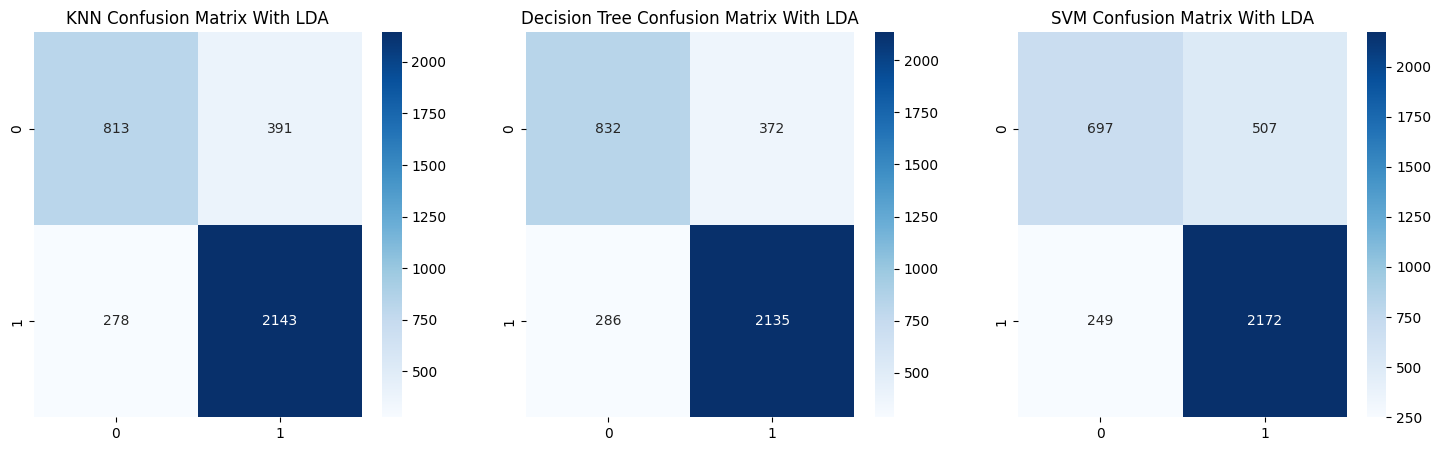

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Vrsimo predikciju koristeci najbolji KNN model
knn_pred_LDA = best_knn_model_LDA.predict(X_test_lda)
knn_conf_matrix_LDA = confusion_matrix(y_test, knn_pred_LDA)

# Vrsimo predikciju koristeci najbolji DTC model
dtc_pred_LDA = best_dtc_model_LDA.predict(X_test_lda)
dtc_conf_matrix_LDA = confusion_matrix(y_test, dtc_pred_LDA)

# Vrsimo predikciju koristeci najbolji SVM model
svm_pred_LDA = best_svm_model_LDA.predict(X_test_lda)
svm_conf_matrix_LDA = confusion_matrix(y_test, svm_pred_LDA)

# Uradicemo prikaz matrica konfuzije za date modele
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# KNN matrica konfuzije
sns.heatmap(knn_conf_matrix_LDA, annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title('KNN Confusion Matrix With LDA')

# DTC matrica konfuzije
sns.heatmap(dtc_conf_matrix_LDA, annot=True, fmt='d', cmap="Blues", ax=axes[1])
axes[1].set_title('Decision Tree Confusion Matrix With LDA')

# SVM matrica konfuzije
sns.heatmap(svm_conf_matrix_LDA, annot=True, fmt='d', cmap="Blues", ax=axes[2])
axes[2].set_title('SVM Confusion Matrix With LDA')

plt.show()

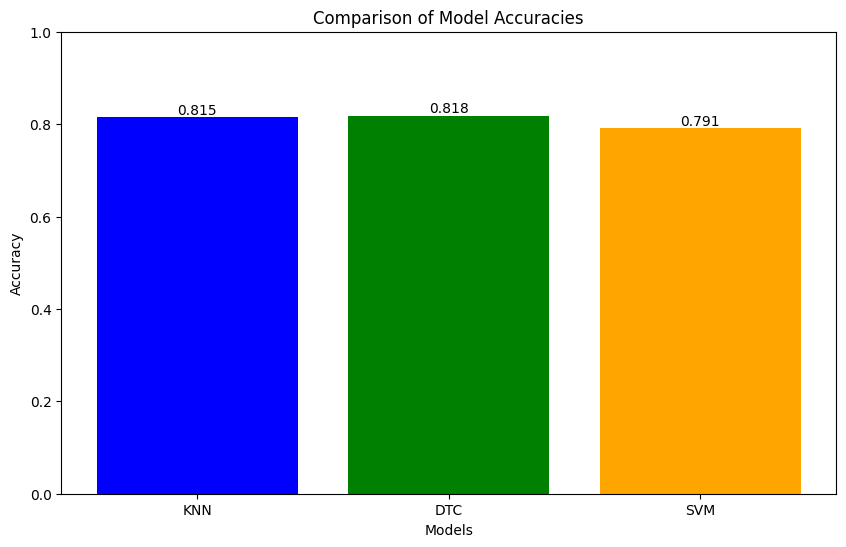

In [43]:
from sklearn.metrics import accuracy_score

# Racunamo preciznosti sva tri modela
accuracy_knn_LDA = accuracy_score(y_test, knn_pred_LDA)
accuracy_dtc_LDA = accuracy_score(y_test, dtc_pred_LDA)
accuracy_svm_LDA = accuracy_score(y_test, svm_pred_LDA)

accuracies_LDA = [accuracy_knn_LDA, accuracy_dtc_LDA, accuracy_svm_LDA]
models = ['KNN', 'DTC', 'SVM']

# Uradicemo bar plot da prikazemo razliku u preciznosti
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies_LDA, color=['blue', 'green', 'orange'])

# Naslov i labele
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Dodajemo preciznosti iznad bar plotova 
for index, value in enumerate(accuracies_LDA):
    plt.text(index, value, str(round(value, 3)), ha='center', va='bottom')

# Ispis slike
plt.ylim(0, 1)
plt.show()